In [2]:
import hdbscan
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import load_npz
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')

# load sparse matrix

In [3]:
X = load_npz("../data_preprocessing/X_tfidf_sparse.npz")

# 降維

In [4]:
import hdbscan
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30)
X_reduced = svd.fit_transform(X.T)  # 注意轉置 → 每個 row 是一部電影


# HDBSCAN

In [5]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
labels = clusterer.fit_predict(X_reduced)  # shape: (num_movies,)

/Users/yuu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yuu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
labels.shape

(496540,)

In [20]:
from collections import Counter

label_counts = Counter(labels)
for label, count in sorted(label_counts.items()):
    if label == -1:
        print(f"Noise: {count} points")
    else:
        print(f"Cluster {label}: {count} points")

Noise: 390997 points
Cluster 0: 50 points
Cluster 1: 24 points
Cluster 2: 128 points
Cluster 3: 45 points
Cluster 4: 42 points
Cluster 5: 30 points
Cluster 6: 87 points
Cluster 7: 71 points
Cluster 8: 102 points
Cluster 9: 141 points
Cluster 10: 54 points
Cluster 11: 79 points
Cluster 12: 29 points
Cluster 13: 50 points
Cluster 14: 21 points
Cluster 15: 78 points
Cluster 16: 44 points
Cluster 17: 136 points
Cluster 18: 24 points
Cluster 19: 206 points
Cluster 20: 32 points
Cluster 21: 187 points
Cluster 22: 21 points
Cluster 23: 204 points
Cluster 24: 28 points
Cluster 25: 88 points
Cluster 26: 36 points
Cluster 27: 83 points
Cluster 28: 136 points
Cluster 29: 28 points
Cluster 30: 193 points
Cluster 31: 94 points
Cluster 32: 114 points
Cluster 33: 194 points
Cluster 34: 28 points
Cluster 35: 167 points
Cluster 36: 215 points
Cluster 37: 43 points
Cluster 38: 41 points
Cluster 39: 395 points
Cluster 40: 26 points
Cluster 41: 156 points
Cluster 42: 104 points
Cluster 43: 20 points
Clust

# draw HDBSCAN result

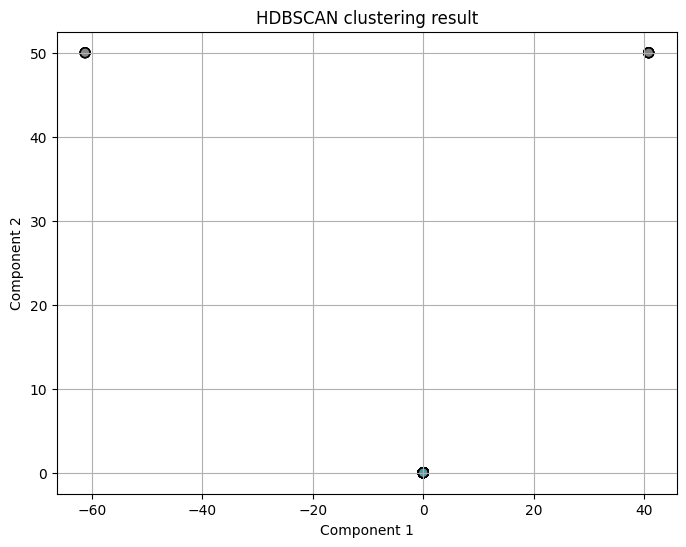

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2).fit_transform(X_reduced)

# 畫圖
plt.figure(figsize=(8, 6))
palette = plt.get_cmap("tab10")
colors = [palette(label) if label >= 0 else (0.5, 0.5, 0.5, 0.5) for label in labels]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=50, edgecolor='k')
plt.title("HDBSCAN clustering result")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

# 將原始dataset依照cluster進行分割

In [9]:
with open('../dataset/movie_new2.txt', 'r') as f:
    lines = f.readlines()

In [10]:
import re
from tqdm import tqdm
def extract_sequence(line):
    pairs = re.findall(r'\((\d+),\s*(\d+)\)', line)
    sequence = [int(pairs[0][0])] + [int(p[1]) for p in pairs]
    return sequence
sequences = [extract_sequence(line) for line in tqdm(lines, desc="Extracting sequences...")]

Extracting sequences...: 100%|██████████| 400000/400000 [00:01<00:00, 227661.07it/s]


In [15]:
movie_ids = sorted(set(movie_id for seq in sequences for movie_id in seq))
movie_id_to_cluster = {movie_id: cluster_label for movie_id, cluster_label in zip(movie_ids, labels)}

In [21]:
from collections import defaultdict

cluster_to_movies = defaultdict(list)
for m, c in movie_id_to_cluster.items():
    if c != -1:  # -1 通常是 noise
        cluster_to_movies[c].append(m)


# 進行 LDP_RM

In [51]:
import sys
from time import time
sys.path.append("../LDP-RM")
from metrics import Metrics
from ldp_rm import LDP_RM
from data_rm import Data
import data_rm

print(dir(Data))  # 看看有沒有 'filter_by_movies'
print(data_rm.__file__)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'candidate_list2mat', 'convert_item2pair', 'est_top_itemsets', 'singleton_count', 'test_itemsets_cand_limit', 'test_length_cand', 'test_length_itemset', 'test_single', 'test_singleton_cand_limit', 'true_conf_cand', 'true_conf_cand1', 'true_conf_cand2', 'true_item_cand', 'true_itemset_cand', 'true_itemset_cand_onlyk']
/Users/yuu/Documents/Projects/LDP-RM/HDBSCAN/../LDP-RM/data_rm.py


In [50]:
for c, movies in cluster_to_movies.items():
    data_c = data_rm.filter_by_movies(movie_list=movies)
    metrics = Metrics(data_c, top_k=64, top_ks=3600, top_kc=32)
    ldp_rm = LDP_RM(data_c, epsilon=4.0, top_k=64, top_ks=3600, top_kc=32, submat=4) 
    for t in range(10):
        t1 = time.time()
        result_fre_dict_svd, result_conf_dict, hitrate_rm = ldp_rm.find_itemset_svd(task='RM', method='AMN', singnum=0.5, use_group=True, group_num=5,
                                                                                    test='test_constant')
        t2 = time.time()
        consume_time = int(t2-t1)
        print('Final mining topks relations:',result_conf_dict)
        print('ldp_rm NCR', ncr:=metrics.NCR(result_conf_dict))
        print('ldp_rm F1', f1:=metrics.F1(result_conf_dict))
        print('ldp_rm VAR', var:=metrics.VARt(result_conf_dict))
        print('time:', ct:=consume_time)
        ncr_sum+= ncr
        f1_sum+=f1
        var_sum+=var
        ct_sum+=ct
    print('average NCR:', round(ncr_sum/10,4))
    print('average F1:', round(f1_sum/10,4))
    print('average consume time:', round(ct_sum/10,4))


AttributeError: module 'data_rm' has no attribute 'filter_by_movies'